<a href="https://colab.research.google.com/github/Yaswanthyarra/GAN-for-microexpression-augmentation/blob/main/GAN_Repression_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


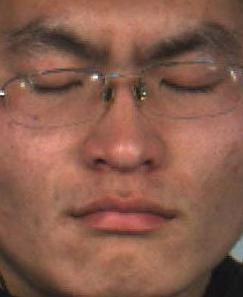

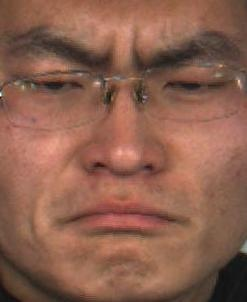

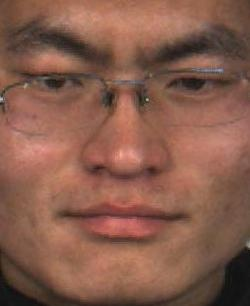

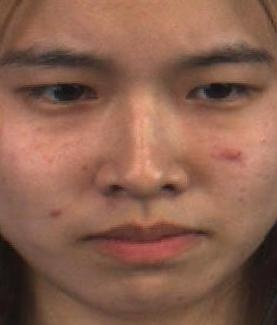

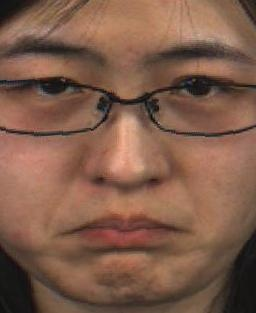

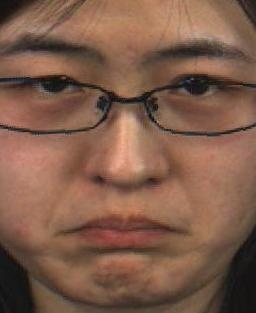

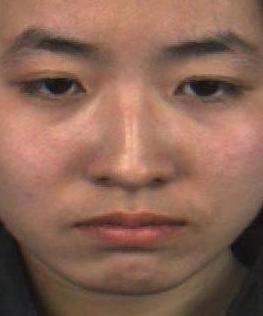

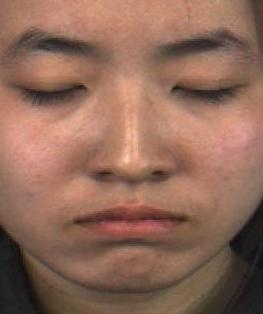

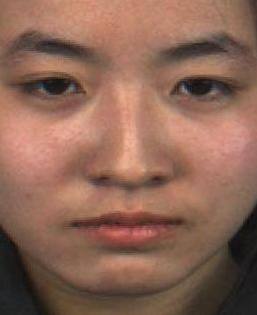

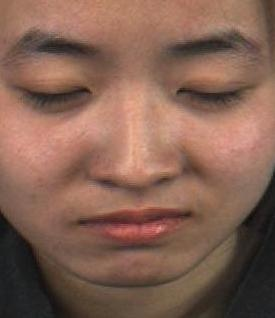

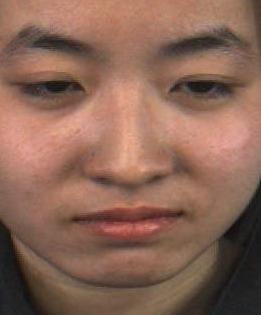

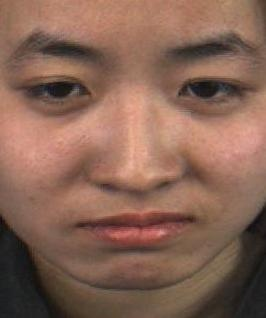

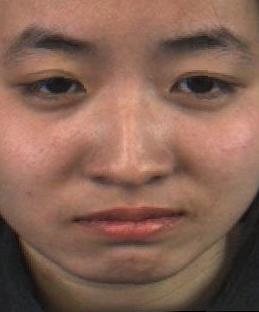

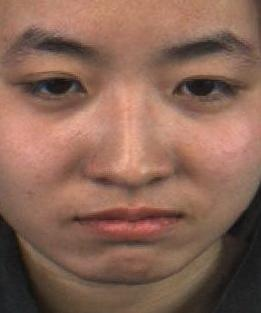

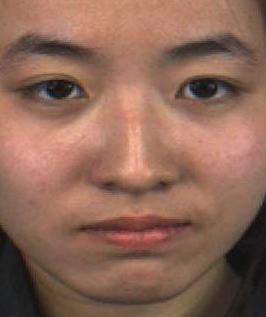

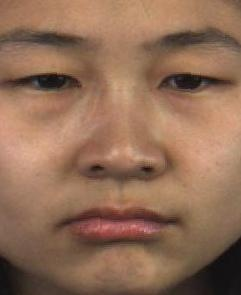

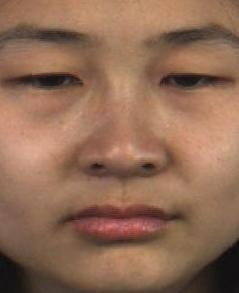

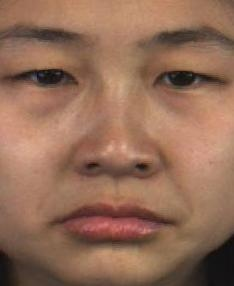

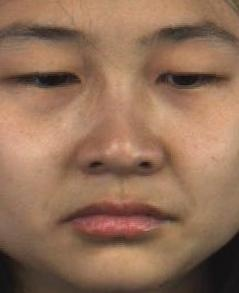

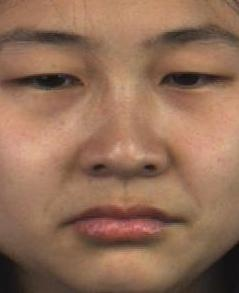

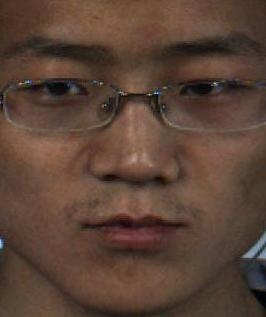

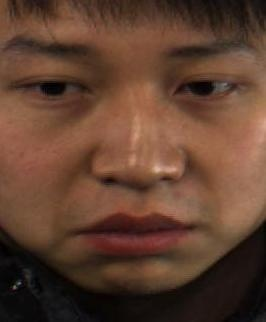

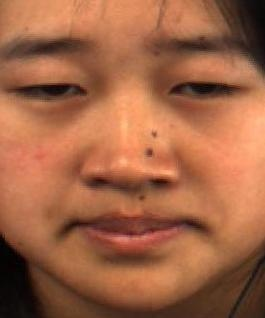

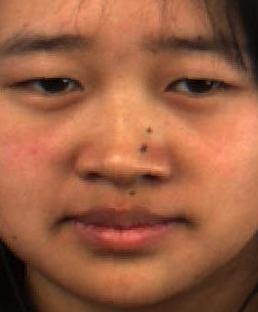

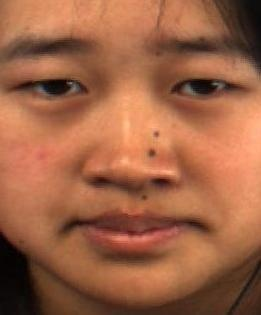

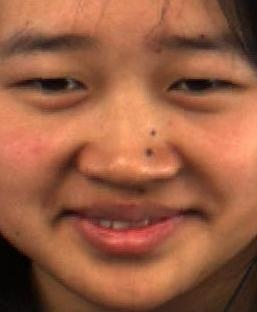

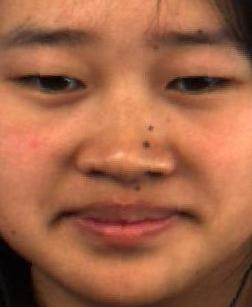

In [4]:
from PIL import Image
import os
from IPython.display import display

# Displaying the intial images in the dataset
dataset_dir = '/content/drive/My Drive/CASMEII/Final_Apex_Frames_Segregated/repression'

for file_name in os.listdir(dataset_dir):
    file_path = os.path.join(dataset_dir, file_name)
    img = Image.open(file_path)
    display(img)

In [5]:
import tensorflow as tf
from tensorflow import keras


#This code creates a Keras dataset from image files in a directory, resizes the images to 64x64 pixels,
#forms batches of 7 images, shuffles them, and normalizes pixel values to [0, 1]

img_microexp_dataset = keras.preprocessing.image_dataset_from_directory(
    directory=dataset_dir, label_mode=None, image_size=(64, 64), batch_size=8,
    shuffle=True, seed=None, validation_split=None,
).map(lambda x: x / 255.0)

Found 27 files belonging to 1 classes.


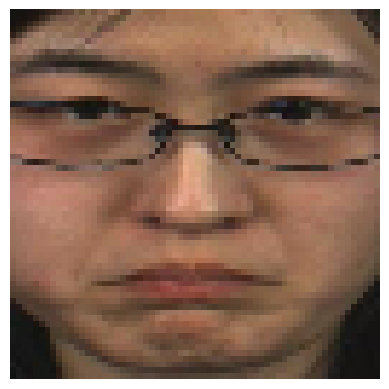

In [6]:
import matplotlib.pyplot as plt
#Displaying the images in the keras dataset
for x in img_microexp_dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [7]:
'''The "discriminator" is a convolutional neural network (CNN) model designed for image classification.
 It takes 64x64x3 input images, applies convolutional and activation layers to learn features,
 and produces a binary output indicating real or fake image (0 to 1).

The "generator" is a deep learning model for generating images.
It takes a noise vector of size latent_dim as input,
 and through a series of transposed convolutional layers,
it gradually upscales the image to 64x64 resolution and
produces RGB images with pixel values in the range [0, 1] using the sigmoid activation function.'''

# Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

'''Conv2D is used for feature extraction and reduction in spatial dimensions,
while Conv2DTranspose is used for upsampling and generating higher-resolution images'''

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)), # 64x64x3
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        # "same" padding so that o/p image = i/p image
        layers.LeakyReLU(alpha=0.2),
        # activation layer that is Leaky version of a Rectified Linear Unit.
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
        # Dense layer of 1 node -> o/p 0 to 1 since sigmoid
    ],
    name="discriminator",
)

latent_dim = 128
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)), # creates 8x8 image
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        # to make image larger for generator
        # After this layer picture is (16x16)
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        # After this layer picture is (32x32)
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        # After this layer picture is (64x64)
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)


In [8]:
# Define an Adam optimizer for the generator model with a learning rate of 0.0001
opt_gen = keras.optimizers.Adam(0.0001)

# Define an Adam optimizer for the discriminator model with the same learning rate of 0.0001
opt_disc = keras.optimizers.Adam(0.0001)

# Create a binary cross-entropy loss function for binary classification tasks, such as GAN training
loss_fn = keras.losses.BinaryCrossentropy()

In [13]:
# Load generator and discriminator weights
generator.load_weights("/content/drive/My Drive/GAN_Models/generator_model_repression.h5")
discriminator.load_weights("/content/drive/My Drive/GAN_Models/discriminator_model_repression.h5")

In [34]:
# Load generator and discriminator weights
generator.load_weights("/content/drive/My Drive/GAN_Models/generator_model_repression.h5")
discriminator.load_weights("/content/drive/My Drive/GAN_Models/discriminator_model_repression.h5")


#tqdm is used to create dynamic progress bars, offering visual feedback on the completion percentage, iteration count, and estimated time remaining for long-running tasks, enhancing user experience.
from tqdm import tqdm
#Training GAN

try:
    for epoch in range(50):
        i=2
        for idx, (real) in enumerate(tqdm(img_microexp_dataset)):
            batch_size = real.shape[0]
            # To create random latent vector
            with tf.GradientTape() as gen_tape:
                random_latent_vectors = tf.random.normal(shape = (batch_size, latent_dim))
                fake = generator(random_latent_vectors)

            # Train Discriminator: max y*log(D(x)) + (1-y) * log(1 - D(G(z))
            with tf.GradientTape() as disc_tape:
                loss_disc_real = loss_fn(tf.ones((batch_size, 1)), discriminator(real))
                loss_disc_fake = loss_fn(tf.zeros((batch_size, 1)), discriminator(fake))
                loss_disc = (loss_disc_real + loss_disc_fake)/2 # Averaging losses

            # To update the weights and apply gradient

            grads = disc_tape.gradient(loss_disc, discriminator.trainable_weights)
            opt_disc.apply_gradients(
                zip(grads, discriminator.trainable_weights)
            )

            # Train Generator: min log(1 - D(G(z)))
            with tf.GradientTape() as gen_tape:
                fake = generator(random_latent_vectors)
                output = discriminator(fake)
                loss_gen = loss_fn(tf.ones(batch_size, 1), output)

            # Compute gradients w.r.t loss of generator
            grads = gen_tape.gradient(loss_gen, generator.trainable_weights)
            opt_gen.apply_gradients(zip(grads, generator.trainable_weights))

    generator.save_weights("/content/drive/My Drive/GAN_Models/generator_model_repression.h5")
    discriminator.save_weights("/content/drive/My Drive/GAN_Models/discriminator_model_repression.h5")
except KeyboardInterrupt:
    pass


 25%|██▌       | 1/4 [00:20<01:01, 20.47s/it]


In [35]:
generator.save_weights("/content/drive/My Drive/GAN_Models/generator_model_repression.h5")
discriminator.save_weights("/content/drive/My Drive/GAN_Models/discriminator_model_repression.h5")

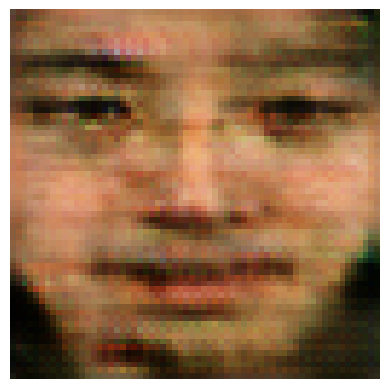

In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming you've already defined and loaded your generator model and have a random_latent_vector
# Generate an image from the random noise

random_latent_vectors = tf.random.normal(shape = (batch_size, latent_dim))
fake = generator(random_latent_vectors)

# Display the generated image
plt.imshow(fake[0])
plt.axis('off')
plt.show()

Saved image: /content/drive/My Drive/GAN_Generated_Images_Repression/generated_img_0.png
Saved image: /content/drive/My Drive/GAN_Generated_Images_Repression/generated_img_1.png
Saved image: /content/drive/My Drive/GAN_Generated_Images_Repression/generated_img_2.png
Saved image: /content/drive/My Drive/GAN_Generated_Images_Repression/generated_img_3.png
Saved image: /content/drive/My Drive/GAN_Generated_Images_Repression/generated_img_4.png
Saved image: /content/drive/My Drive/GAN_Generated_Images_Repression/generated_img_5.png
Saved image: /content/drive/My Drive/GAN_Generated_Images_Repression/generated_img_6.png
Saved image: /content/drive/My Drive/GAN_Generated_Images_Repression/generated_img_7.png
Saved image: /content/drive/My Drive/GAN_Generated_Images_Repression/generated_img_8.png
Saved image: /content/drive/My Drive/GAN_Generated_Images_Repression/generated_img_9.png
Saved image: /content/drive/My Drive/GAN_Generated_Images_Repression/generated_img_10.png
Saved image: /conten

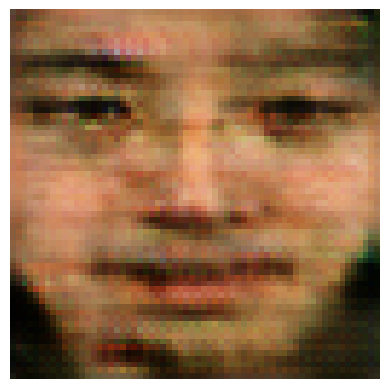

In [37]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming you've already defined and loaded your generator model and have a random_latent_vector

# Generate a batch of images from the random noise


# Create a directory to save the generated images if it doesn't exist
output_dir = "/content/drive/My Drive/GAN_Generated_Images_Repression/"
os.makedirs(output_dir, exist_ok=True)

# Save and display each generated image in the batch
for i in range(32):
    random_latent_vectors = tf.random.normal(shape = (batch_size, latent_dim))
    generated_image = generator(random_latent_vectors)
    img = keras.preprocessing.image.array_to_img(generated_image[0])
    save_path = os.path.join(output_dir, "generated_img_%d.png" % (i))
    img.save(save_path)
    print("Saved image:", save_path)


# Display the first generated image
plt.imshow(fake[0])
plt.axis('off')
plt.show()